In [29]:
import librosa
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,Model
from keras import layers
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import numpy as np
import os
from sklearn.model_selection import train_test_split

In [30]:
#y_c,sr_c=librosa.load('chinese.wav',sr=16000)
#y_e,sr_e=librosa.load('e_trim.wav',sr=16000)
#mat_c=librosa.feature.mfcc(y=y_c,sr=sr,n_mfcc=64,n_fft=int(sr*0.025),hop_length=int(sr*0.010))
#print(y_c.shape,sr,mat_c.shape)
#mat_e=librosa.feature.mfcc(y=y_e,sr=sr,n_mfcc=64,n_fft=int(sr*0.025),hop_length=int(sr*0.010))
#print(y_e.shape,sr,mat_e.shape)

In [31]:
# each data has a sequence less than 60000
ENG_DIR = 'C:/Users/ME/Desktop/mfcctrain/train/english/'
HIN_DIR = 'C:/Users/ME/Desktop/mfcctrain/train/hindi/'
CHN_DIR = 'C:/Users/ME/Desktop/mfcctrain/train/mandarin/'

def load_voicedata(num_eng, num_chn, num_hin, length):
    eng_data = np.zeros((num_eng, 64, length), dtype=float)
    eng_labels = np.zeros((num_eng, 1), dtype=float)
    chn_data = np.zeros((num_chn, 64, length), dtype=float)
    chn_labels = np.ones((num_chn, 1), dtype=float) * 2
    hin_data = np.zeros((num_hin, 64, length), dtype=float)
    hin_labels = np.ones((num_hin, 1), dtype=float)
    eng_voice = [ENG_DIR + i for i in os.listdir(ENG_DIR)]
    chn_voice = [CHN_DIR + i for i in os.listdir(CHN_DIR)]
    hin_voice = [HIN_DIR + i for i in os.listdir(HIN_DIR)]
    for i, eng_file in enumerate(eng_voice):
        read_data = np.load(eng_file)
        eng_data[i] = read_data[:, :length]
        if i == num_eng - 1:
            break
    print('finished preparing english data')
    for i, chn_file in enumerate(chn_voice):
        read_data = np.load(chn_file)
        chn_data[i] = read_data[:, :length]
        if i == num_chn - 1:
            break
    print('finished preparing madarin data')
    for i, hin_file in enumerate(hin_voice):
        read_data = np.load(hin_file)
        hin_data[i] = read_data[:, :length]
        if i == num_hin - 1:
            break
    print('finished preparing hindi data')
    data = np.concatenate((eng_data, chn_data, hin_data), axis=0)
    labels = np.concatenate((eng_labels, chn_labels, hin_labels), axis=0)
    print('finished preparing data')
    print('data size', data.shape)
    return data, labels


In [33]:
data, labels = load_voicedata(60, 60, 60, 20000)


finished preparing english data


finished preparing madarin data


finished preparing hindi data


finished preparing data
data size (180, 64, 20000)


In [34]:
def data_preprocessing(input_data, input_labels):
    data_mean_mid = input_data.mean(axis=0)
    data_mean = data_mean_mid.mean(axis=1)
    data_std_mid = input_data.std(axis=0)
    data_std = data_std_mid.std(axis=1)
    output_data = input_data
    for i in range(0, len(input_data)):
        for j in range(0, input_data.shape[2]):
            output_data[i, :, j] -= data_mean
            output_data[i, :, j] = output_data[i, :, j] / data_std
    #    output_data=(input_data-data_mean)/data_std
    output_labels = np.zeros((len(input_data), 3), dtype=float)
    for i in range(0, len(input_data)):
        if input_labels[i] == 0:
            output_labels[i, 0] = 1
        elif input_labels[i] == 1:
            output_labels[i, 1] = 1
        else:
            output_labels[i, 2] = 1
    print('finish data preprocessing, get standard data and one hot labels')
    return output_data, output_labels


In [35]:
all_data, all_labels = data_preprocessing(data, labels)


finish data preprocessing, get standard data and one hot labels


In [36]:
# seperate full length of 50000 sequence into a simple length, and seperate to gene_times apart, try each_length=1000(10s), generate 20 times
def data_generator(input_data, input_labels, each_length, gene_times):
    gene_data = np.zeros((len(input_data) * gene_times, 64, each_length), dtype=float)
    gene_labels = np.zeros((len(input_data) * gene_times, 3), dtype=float)
    for i in range(0, len(input_data)):
        for j in range(0, gene_times):
            gene_data[i * gene_times + j] = input_data[i, :,
                                            j * (each_length + 100):j * (each_length + 100) + each_length]
            gene_labels[i * gene_times + j] = input_labels[i]

    return gene_data, gene_labels


In [37]:
gene_data, gene_labels = data_generator(all_data, all_labels, each_length=600, gene_times=25)
gene_data = np.reshape(gene_data, (len(gene_data), 600, 64))
train_data, val_data, train_labels, val_labels = train_test_split(gene_data, gene_labels, test_size=0.1666)
print('train size:', train_data.shape, 'label size:', train_labels.shape)


train size: (3750, 600, 64) label size: (3750, 3)


In [38]:
def show_plot():
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def get_hot_value(prediction_list):
    hot_list = np.zeros((prediction_list.shape[0], prediction_list.shape[1]), int)
    for i in range(0, len(prediction_list)):
        max_val, hot_oneline, max_found = max(prediction_list[i]), [], False
        for item in prediction_list[i]:
            if item == max_val and not max_found:
                hot_oneline.append(1)
                max_found = True
            else:
                hot_oneline.append(0)
        hot_list[i, :] = hot_oneline
        #print(hot_list)
    return hot_list

def detail(label, predictions):
    n_right = 0
    n_wrong = 0
    pred_onehot = get_hot_value(predictions)
    n_wrongclassified = np.zeros((predictions.shape[1]), int)  #classified as a label(in predictions), but is not
    n_rightclassified = np.zeros((predictions.shape[1]), int)
    n_allclassified = pred_onehot.sum(axis=0)
    n_alllabeled = label.sum(axis=0)
    for i in range(0, len(predictions)):
        if (label[i] == pred_onehot[i]).all():
            n_right += 1
            n_rightclassified += pred_onehot[i]
        else:
            n_wrong += 1
            n_wrongclassified += pred_onehot[i]
    accuracy = n_right / len(predictions)
    return accuracy, n_wrongclassified, n_rightclassified, n_allclassified, n_alllabeled.astype(int)
def performance():
    prediction = model.predict(val_data, verbose=0)
    prediction = prediction.sum()
    accu = detail(val_labels, prediction)
    print('detail of training image')
    print('for test accuracy is %f' % accu[0])
    print('wrong prediction of train label', accu[1])
    print('right prediction of train label', accu[2])
    print('prediction of train label      ', accu[3])
    print('true of train label            ', accu[4])
    show_plot()
    return prediction, accu


In [85]:
def model_GRU():
    model = Sequential()
    # model.add(layers.GRU(64,
    #                      dropout=0.1,
    #                      recurrent_dropout=0.5,
    #                      return_sequences=True,
    #                      input_shape=(600, gene_data.shape[-1])))
    #model.add(layers.Dense(64, activation='relu'))
    model.add(layers.GRU(32,
                         dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(600, gene_data.shape[-1])))
    #model.add(layers.Dense(32, activation='relu'))
    model.add(layers.GRU(16,
                         dropout=0.1,
                         recurrent_dropout=0.5,
                         return_sequences=True,
                         input_shape=(32, gene_data.shape[-1])))
    model.add(layers.Flatten()) 
    model.add(layers.Dense(8, activation='relu'))
    #    model.add(layers.Flatten())
    #model.add(layers.Dense(32, activation='relu'))
    #model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    #    model.add(Activation('sigmoid'))
    return model

def model_LSTM():
    model = Sequential()
    model.add(layers.LSTM(32,
                          dropout=0.1,
                          recurrent_dropout=0.5,
                          return_sequences=True,
                          input_shape=(None, 64)))
    model.add(layers.LSTM(4,
                          dropout=0.3,
                          recurrent_dropout=0.5,
                          return_sequences=True))
    #    model.add(layers.Flatten())
    model.add(layers.TimeDistributed(layers.Dense(activation='relu',
                                                  units=32)))
    #    model.add(layers.Dense(16,activation='relu'))
    #    model.add(layers.Flatten())
    model.add(layers.Dense(3, activation='softmax'))
    #    model.add(Activation('sigmoid'))
    return model

model = model_GRU()
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_40 (GRU)                 (None, 600, 32)           9312      
_________________________________________________________________
gru_41 (GRU)                 (None, 600, 16)           2352      
_________________________________________________________________
flatten_19 (Flatten)         (None, 9600)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 8)                 76808     
_________________________________________________________________
dense_52 (Dense)             (None, 3)                 27        
Total params: 88,499
Trainable params: 88,499
Non-trainable params: 0
_________________________________________________________________


In [86]:
import numpy as np
n_batch = 32
n_epoch = 10
#train_data_new=train_data.reshape(1200,1,1,64, 600)
train_labels_re = np.reshape(train_labels, (train_labels.shape[0], 1, 3))
print(train_data.shape)
print(train_labels.shape)
train_data_re = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], train_data.shape[2]))
print('input data shape:', train_data_re.shape, 'input label shape:', train_labels_re.shape, 'batch size', n_batch)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')

history = model.fit(train_data_re, train_labels, epochs=n_epoch, batch_size=n_batch,
                    validation_split=0.2, callbacks=[early_stopping])


(3750, 600, 64)
(3750, 3)
input data shape: (3750, 600, 64) input label shape: (3750, 1, 3) batch size 32


Train on 3000 samples, validate on 750 samples
Epoch 1/10


  32/3000 [..............................] - ETA: 7:08 - loss: 1.1305

  64/3000 [..............................] - ETA: 3:47 - loss: 1.1782

  96/3000 [..............................] - ETA: 2:41 - loss: 1.2598

 128/3000 [>.............................] - ETA: 2:08 - loss: 1.2030

 160/3000 [>.............................] - ETA: 1:47 - loss: 1.1915

 192/3000 [>.............................] - ETA: 1:34 - loss: 1.1127

 224/3000 [=>............................] - ETA: 1:25 - loss: 1.1069

 256/3000 [=>............................] - ETA: 1:17 - loss: 1.1021

 288/3000 [=>............................] - ETA: 1:12 - loss: 1.0741

 320/3000 [==>...........................] - ETA: 1:08 - loss: 1.0696

 352/3000 [==>...........................] - ETA: 1:05 - loss: 1.0601

 384/3000 [==>...........................] - ETA: 1:02 - loss: 1.0488

 416/3000 [===>..........................] - ETA: 1:00 - loss: 1.0519

 448/3000 [===>..........................] - ETA: 57s - loss: 1.0295 

 480/3000 [===>..........................] - ETA: 55s - loss: 1.0242

 512/3000 [====>.........................] - ETA: 53s - loss: 1.0131

 544/3000 [====>.........................] - ETA: 52s - loss: 1.0135

 576/3000 [====>.........................] - ETA: 50s - loss: 1.0030

 608/3000 [=====>........................] - ETA: 49s - loss: 0.9875

 640/3000 [=====>........................] - ETA: 48s - loss: 0.9832

 672/3000 [=====>........................] - ETA: 47s - loss: 0.9799

 704/3000 [======>.......................] - ETA: 46s - loss: 0.9660

 736/3000 [======>.......................] - ETA: 45s - loss: 0.9729

 768/3000 [======>.......................] - ETA: 44s - loss: 0.9708

 800/3000 [=======>......................] - ETA: 43s - loss: 0.9720

 832/3000 [=======>......................] - ETA: 42s - loss: 0.9705

 864/3000 [=======>......................] - ETA: 41s - loss: 0.9650

 896/3000 [=======>......................] - ETA: 40s - loss: 0.9697

 928/3000 [========>.....................] - ETA: 39s - loss: 0.9725

 960/3000 [========>.....................] - ETA: 38s - loss: 0.9723

 992/3000 [========>.....................] - ETA: 37s - loss: 0.9689

1024/3000 [=========>....................] - ETA: 36s - loss: 0.9642

1056/3000 [=========>....................] - ETA: 35s - loss: 0.9639

1088/3000 [=========>....................] - ETA: 34s - loss: 0.9660

1120/3000 [==========>...................] - ETA: 33s - loss: 0.9646

1152/3000 [==========>...................] - ETA: 32s - loss: 0.9626

1184/3000 [==========>...................] - ETA: 32s - loss: 0.9625

1216/3000 [===========>..................] - ETA: 31s - loss: 0.9615

1248/3000 [===========>..................] - ETA: 30s - loss: 0.9588

1280/3000 [===========>..................] - ETA: 29s - loss: 0.9583

1312/3000 [============>.................] - ETA: 29s - loss: 0.9571

1344/3000 [============>.................] - ETA: 28s - loss: 0.9570

1376/3000 [============>.................] - ETA: 27s - loss: 0.9543

1408/3000 [=============>................] - ETA: 27s - loss: 0.9549

1440/3000 [=============>................] - ETA: 26s - loss: 0.9539

1472/3000 [=============>................] - ETA: 25s - loss: 0.9556

1504/3000 [==============>...............] - ETA: 25s - loss: 0.9557

1536/3000 [==============>...............] - ETA: 24s - loss: 0.9536

1568/3000 [==============>...............] - ETA: 23s - loss: 0.9515

1600/3000 [===============>..............] - ETA: 23s - loss: 0.9493

1632/3000 [===============>..............] - ETA: 22s - loss: 0.9472

1664/3000 [===============>..............] - ETA: 22s - loss: 0.9513

1696/3000 [===============>..............] - ETA: 21s - loss: 0.9532

1728/3000 [================>.............] - ETA: 21s - loss: 0.9500

1760/3000 [================>.............] - ETA: 20s - loss: 0.9470

1792/3000 [================>.............] - ETA: 20s - loss: 0.9483

1824/3000 [=================>............] - ETA: 19s - loss: 0.9478

1856/3000 [=================>............] - ETA: 18s - loss: 0.9471

1888/3000 [=================>............] - ETA: 18s - loss: 0.9448

1920/3000 [==================>...........] - ETA: 17s - loss: 0.9433

1952/3000 [==================>...........] - ETA: 17s - loss: 0.9453

1984/3000 [==================>...........] - ETA: 16s - loss: 0.9427

2016/3000 [===================>..........] - ETA: 16s - loss: 0.9431

2048/3000 [===================>..........] - ETA: 15s - loss: 0.9411

2080/3000 [===================>..........] - ETA: 14s - loss: 0.9404

2112/3000 [====================>.........] - ETA: 14s - loss: 0.9429

2144/3000 [====================>.........] - ETA: 13s - loss: 0.9404

2176/3000 [====================>.........] - ETA: 13s - loss: 0.9504

2208/3000 [=====================>........] - ETA: 12s - loss: 0.9496

2240/3000 [=====================>........] - ETA: 12s - loss: 0.9477

2272/3000 [=====================>........] - ETA: 11s - loss: 0.9467

2304/3000 [======================>.......] - ETA: 11s - loss: 0.9461

2336/3000 [======================>.......] - ETA: 10s - loss: 0.9444

2368/3000 [======================>.......] - ETA: 10s - loss: 0.9428

2400/3000 [=======================>......] - ETA: 9s - loss: 0.9413 

2432/3000 [=======================>......] - ETA: 9s - loss: 0.9432

2464/3000 [=======================>......] - ETA: 8s - loss: 0.9424

2496/3000 [=======================>......] - ETA: 8s - loss: 0.9414

2528/3000 [========================>.....] - ETA: 7s - loss: 0.9396

2560/3000 [========================>.....] - ETA: 7s - loss: 0.9378

2592/3000 [========================>.....] - ETA: 6s - loss: 0.9354

2624/3000 [=========================>....] - ETA: 5s - loss: 0.9330

2656/3000 [=========================>....] - ETA: 5s - loss: 0.9342

2688/3000 [=========================>....] - ETA: 4s - loss: 0.9370

2720/3000 [==========================>...] - ETA: 4s - loss: 0.9369

2752/3000 [==========================>...] - ETA: 3s - loss: 0.9370

2784/3000 [==========================>...] - ETA: 3s - loss: 0.9357

2816/3000 [===========================>..] - ETA: 2s - loss: 0.9351

2848/3000 [===========================>..] - ETA: 2s - loss: 0.9359

2880/3000 [===========================>..] - ETA: 1s - loss: 0.9356

2912/3000 [============================>.] - ETA: 1s - loss: 0.9347

2944/3000 [============================>.] - ETA: 0s - loss: 0.9345

2976/3000 [============================>.] - ETA: 0s - loss: 0.9335

3000/3000 [==============================] - 49s 16ms/step - loss: 0.9336 - val_loss: 0.8661


Epoch 2/10


  32/3000 [..............................] - ETA: 36s - loss: 0.7954

  64/3000 [..............................] - ETA: 35s - loss: 0.7574

  96/3000 [..............................] - ETA: 35s - loss: 0.7424

 128/3000 [>.............................] - ETA: 34s - loss: 0.7623

 160/3000 [>.............................] - ETA: 34s - loss: 0.7189

 192/3000 [>.............................] - ETA: 33s - loss: 0.7465

 224/3000 [=>............................] - ETA: 33s - loss: 0.7460

 256/3000 [=>............................] - ETA: 33s - loss: 0.7387

 288/3000 [=>............................] - ETA: 32s - loss: 0.7385

 320/3000 [==>...........................] - ETA: 32s - loss: 0.7455

 352/3000 [==>...........................] - ETA: 32s - loss: 0.7580

 384/3000 [==>...........................] - ETA: 32s - loss: 0.7663

 416/3000 [===>..........................] - ETA: 31s - loss: 0.7632

 448/3000 [===>..........................] - ETA: 31s - loss: 0.7514

 480/3000 [===>..........................] - ETA: 31s - loss: 0.7524

 512/3000 [====>.........................] - ETA: 30s - loss: 0.7482

 544/3000 [====>.........................] - ETA: 30s - loss: 0.7526

 576/3000 [====>.........................] - ETA: 29s - loss: 0.7522

 608/3000 [=====>........................] - ETA: 29s - loss: 0.7494

 640/3000 [=====>........................] - ETA: 29s - loss: 0.7494

 672/3000 [=====>........................] - ETA: 28s - loss: 0.7400

 704/3000 [======>.......................] - ETA: 28s - loss: 0.7479

 736/3000 [======>.......................] - ETA: 28s - loss: 0.7564

 768/3000 [======>.......................] - ETA: 27s - loss: 0.7486

 800/3000 [=======>......................] - ETA: 27s - loss: 0.7520

 832/3000 [=======>......................] - ETA: 27s - loss: 0.7484

 864/3000 [=======>......................] - ETA: 26s - loss: 0.7560

 896/3000 [=======>......................] - ETA: 26s - loss: 0.7577

 928/3000 [========>.....................] - ETA: 25s - loss: 0.7574

 960/3000 [========>.....................] - ETA: 25s - loss: 0.7586

 992/3000 [========>.....................] - ETA: 25s - loss: 0.7569

1024/3000 [=========>....................] - ETA: 24s - loss: 0.7553

1056/3000 [=========>....................] - ETA: 24s - loss: 0.7588

1088/3000 [=========>....................] - ETA: 23s - loss: 0.7590

1120/3000 [==========>...................] - ETA: 23s - loss: 0.7641

1152/3000 [==========>...................] - ETA: 23s - loss: 0.7608

1184/3000 [==========>...................] - ETA: 22s - loss: 0.7668

1216/3000 [===========>..................] - ETA: 22s - loss: 0.7651

1248/3000 [===========>..................] - ETA: 22s - loss: 0.7650

1280/3000 [===========>..................] - ETA: 21s - loss: 0.7649

1312/3000 [============>.................] - ETA: 21s - loss: 0.7670

1344/3000 [============>.................] - ETA: 20s - loss: 0.7668

1376/3000 [============>.................] - ETA: 20s - loss: 0.7653

1408/3000 [=============>................] - ETA: 20s - loss: 0.7648

1440/3000 [=============>................] - ETA: 19s - loss: 0.7637

1472/3000 [=============>................] - ETA: 19s - loss: 0.7627

1504/3000 [==============>...............] - ETA: 18s - loss: 0.7602

1536/3000 [==============>...............] - ETA: 18s - loss: 0.7597

1568/3000 [==============>...............] - ETA: 18s - loss: 0.7578

1600/3000 [===============>..............] - ETA: 17s - loss: 0.7617

1632/3000 [===============>..............] - ETA: 17s - loss: 0.7600

1664/3000 [===============>..............] - ETA: 16s - loss: 0.7601

1696/3000 [===============>..............] - ETA: 16s - loss: 0.7600

1728/3000 [================>.............] - ETA: 16s - loss: 0.7601

1760/3000 [================>.............] - ETA: 15s - loss: 0.7588

1792/3000 [================>.............] - ETA: 15s - loss: 0.7601

1824/3000 [=================>............] - ETA: 14s - loss: 0.7631

1856/3000 [=================>............] - ETA: 14s - loss: 0.7622

1888/3000 [=================>............] - ETA: 14s - loss: 0.7634

1920/3000 [==================>...........] - ETA: 13s - loss: 0.7627

1952/3000 [==================>...........] - ETA: 13s - loss: 0.7629

1984/3000 [==================>...........] - ETA: 12s - loss: 0.7628

2016/3000 [===================>..........] - ETA: 12s - loss: 0.7641

2048/3000 [===================>..........] - ETA: 12s - loss: 0.7646

2080/3000 [===================>..........] - ETA: 11s - loss: 0.7663

2112/3000 [====================>.........] - ETA: 11s - loss: 0.7652

2144/3000 [====================>.........] - ETA: 10s - loss: 0.7647

2176/3000 [====================>.........] - ETA: 10s - loss: 0.7647

2208/3000 [=====================>........] - ETA: 10s - loss: 0.7657

2240/3000 [=====================>........] - ETA: 9s - loss: 0.7645 

2272/3000 [=====================>........] - ETA: 9s - loss: 0.7637

2304/3000 [======================>.......] - ETA: 8s - loss: 0.7643

2336/3000 [======================>.......] - ETA: 8s - loss: 0.7624

2368/3000 [======================>.......] - ETA: 7s - loss: 0.7632

2400/3000 [=======================>......] - ETA: 7s - loss: 0.7642

2432/3000 [=======================>......] - ETA: 7s - loss: 0.7643

2464/3000 [=======================>......] - ETA: 6s - loss: 0.7630

2496/3000 [=======================>......] - ETA: 6s - loss: 0.7621

2528/3000 [========================>.....] - ETA: 5s - loss: 0.7598

2560/3000 [========================>.....] - ETA: 5s - loss: 0.7581

2592/3000 [========================>.....] - ETA: 5s - loss: 0.7584

2624/3000 [=========================>....] - ETA: 4s - loss: 0.7621

2656/3000 [=========================>....] - ETA: 4s - loss: 0.7620

2688/3000 [=========================>....] - ETA: 3s - loss: 0.7621

2720/3000 [==========================>...] - ETA: 3s - loss: 0.7630

2752/3000 [==========================>...] - ETA: 3s - loss: 0.7628

2784/3000 [==========================>...] - ETA: 2s - loss: 0.7652

2816/3000 [===========================>..] - ETA: 2s - loss: 0.7666

2848/3000 [===========================>..] - ETA: 1s - loss: 0.7654

2880/3000 [===========================>..] - ETA: 1s - loss: 0.7654

2912/3000 [============================>.] - ETA: 1s - loss: 0.7657

2944/3000 [============================>.] - ETA: 0s - loss: 0.7649

2976/3000 [============================>.] - ETA: 0s - loss: 0.7649

3000/3000 [==============================] - 39s 13ms/step - loss: 0.7661 - val_loss: 0.8605


Epoch 3/10


  32/3000 [..............................] - ETA: 36s - loss: 0.5472

  64/3000 [..............................] - ETA: 36s - loss: 0.5990

  96/3000 [..............................] - ETA: 35s - loss: 0.6873

 128/3000 [>.............................] - ETA: 35s - loss: 0.6853

 160/3000 [>.............................] - ETA: 34s - loss: 0.6600

 192/3000 [>.............................] - ETA: 34s - loss: 0.6315

 224/3000 [=>............................] - ETA: 33s - loss: 0.6443

 256/3000 [=>............................] - ETA: 33s - loss: 0.6281

 288/3000 [=>............................] - ETA: 32s - loss: 0.6360

 320/3000 [==>...........................] - ETA: 32s - loss: 0.6343

 352/3000 [==>...........................] - ETA: 31s - loss: 0.6308

 384/3000 [==>...........................] - ETA: 31s - loss: 0.6416

 416/3000 [===>..........................] - ETA: 30s - loss: 0.6382

 448/3000 [===>..........................] - ETA: 30s - loss: 0.6463

 480/3000 [===>..........................] - ETA: 29s - loss: 0.6368

 512/3000 [====>.........................] - ETA: 29s - loss: 0.6364

 544/3000 [====>.........................] - ETA: 29s - loss: 0.6360

 576/3000 [====>.........................] - ETA: 28s - loss: 0.6350

 608/3000 [=====>........................] - ETA: 28s - loss: 0.6317

 640/3000 [=====>........................] - ETA: 27s - loss: 0.6396

 672/3000 [=====>........................] - ETA: 27s - loss: 0.6347

 704/3000 [======>.......................] - ETA: 27s - loss: 0.6420

 736/3000 [======>.......................] - ETA: 26s - loss: 0.6483

 768/3000 [======>.......................] - ETA: 26s - loss: 0.6569

 800/3000 [=======>......................] - ETA: 25s - loss: 0.6563

 832/3000 [=======>......................] - ETA: 25s - loss: 0.6596

 864/3000 [=======>......................] - ETA: 25s - loss: 0.6558

 896/3000 [=======>......................] - ETA: 24s - loss: 0.6568

 928/3000 [========>.....................] - ETA: 24s - loss: 0.6540

 960/3000 [========>.....................] - ETA: 24s - loss: 0.6566

 992/3000 [========>.....................] - ETA: 23s - loss: 0.6568

1024/3000 [=========>....................] - ETA: 23s - loss: 0.6556

1056/3000 [=========>....................] - ETA: 22s - loss: 0.6545

1088/3000 [=========>....................] - ETA: 22s - loss: 0.6588

1120/3000 [==========>...................] - ETA: 22s - loss: 0.6620

1152/3000 [==========>...................] - ETA: 21s - loss: 0.6581

1184/3000 [==========>...................] - ETA: 21s - loss: 0.6604

1216/3000 [===========>..................] - ETA: 20s - loss: 0.6566

1248/3000 [===========>..................] - ETA: 20s - loss: 0.6550

1280/3000 [===========>..................] - ETA: 20s - loss: 0.6544

1312/3000 [============>.................] - ETA: 19s - loss: 0.6587

1344/3000 [============>.................] - ETA: 19s - loss: 0.6588

1376/3000 [============>.................] - ETA: 19s - loss: 0.6622

1408/3000 [=============>................] - ETA: 18s - loss: 0.6648

1440/3000 [=============>................] - ETA: 18s - loss: 0.6648

1472/3000 [=============>................] - ETA: 18s - loss: 0.6625

1504/3000 [==============>...............] - ETA: 17s - loss: 0.6614

1536/3000 [==============>...............] - ETA: 17s - loss: 0.6590

1568/3000 [==============>...............] - ETA: 17s - loss: 0.6570

1600/3000 [===============>..............] - ETA: 16s - loss: 0.6607

1632/3000 [===============>..............] - ETA: 16s - loss: 0.6605

1664/3000 [===============>..............] - ETA: 16s - loss: 0.6633

1696/3000 [===============>..............] - ETA: 15s - loss: 0.6663

1728/3000 [================>.............] - ETA: 15s - loss: 0.6665

1760/3000 [================>.............] - ETA: 14s - loss: 0.6666

1792/3000 [================>.............] - ETA: 14s - loss: 0.6663

1824/3000 [=================>............] - ETA: 14s - loss: 0.6667

1856/3000 [=================>............] - ETA: 13s - loss: 0.6671

1888/3000 [=================>............] - ETA: 13s - loss: 0.6656

1920/3000 [==================>...........] - ETA: 13s - loss: 0.6639

1952/3000 [==================>...........] - ETA: 12s - loss: 0.6637

1984/3000 [==================>...........] - ETA: 12s - loss: 0.6625

2016/3000 [===================>..........] - ETA: 11s - loss: 0.6634

2048/3000 [===================>..........] - ETA: 11s - loss: 0.6627

2080/3000 [===================>..........] - ETA: 11s - loss: 0.6614

2112/3000 [====================>.........] - ETA: 10s - loss: 0.6611

2144/3000 [====================>.........] - ETA: 10s - loss: 0.6602

2176/3000 [====================>.........] - ETA: 9s - loss: 0.6617 

2208/3000 [=====================>........] - ETA: 9s - loss: 0.6622

2240/3000 [=====================>........] - ETA: 9s - loss: 0.6621

2272/3000 [=====================>........] - ETA: 8s - loss: 0.6618

2304/3000 [======================>.......] - ETA: 8s - loss: 0.6599

2336/3000 [======================>.......] - ETA: 7s - loss: 0.6591

2368/3000 [======================>.......] - ETA: 7s - loss: 0.6587

2400/3000 [=======================>......] - ETA: 7s - loss: 0.6587

2432/3000 [=======================>......] - ETA: 6s - loss: 0.6581

2464/3000 [=======================>......] - ETA: 6s - loss: 0.6602

2496/3000 [=======================>......] - ETA: 6s - loss: 0.6599

2528/3000 [========================>.....] - ETA: 5s - loss: 0.6603

2560/3000 [========================>.....] - ETA: 5s - loss: 0.6615

2592/3000 [========================>.....] - ETA: 4s - loss: 0.6617

2624/3000 [=========================>....] - ETA: 4s - loss: 0.6616

2656/3000 [=========================>....] - ETA: 4s - loss: 0.6629

2688/3000 [=========================>....] - ETA: 3s - loss: 0.6649

2720/3000 [==========================>...] - ETA: 3s - loss: 0.6647

2752/3000 [==========================>...] - ETA: 2s - loss: 0.6648

2784/3000 [==========================>...] - ETA: 2s - loss: 0.6642

2816/3000 [===========================>..] - ETA: 2s - loss: 0.6655

2848/3000 [===========================>..] - ETA: 1s - loss: 0.6645

2880/3000 [===========================>..] - ETA: 1s - loss: 0.6634

2912/3000 [============================>.] - ETA: 1s - loss: 0.6642

2944/3000 [============================>.] - ETA: 0s - loss: 0.6633

2976/3000 [============================>.] - ETA: 0s - loss: 0.6628

3000/3000 [==============================] - 38s 13ms/step - loss: 0.6613 - val_loss: 0.8495


Epoch 4/10


  32/3000 [..............................] - ETA: 35s - loss: 0.5867

  64/3000 [..............................] - ETA: 33s - loss: 0.5778

  96/3000 [..............................] - ETA: 33s - loss: 0.5691

 128/3000 [>.............................] - ETA: 33s - loss: 0.5232

 160/3000 [>.............................] - ETA: 33s - loss: 0.5345

 192/3000 [>.............................] - ETA: 33s - loss: 0.5342

 224/3000 [=>............................] - ETA: 32s - loss: 0.5329

 256/3000 [=>............................] - ETA: 32s - loss: 0.5317

 288/3000 [=>............................] - ETA: 31s - loss: 0.5219

 320/3000 [==>...........................] - ETA: 31s - loss: 0.5175

 352/3000 [==>...........................] - ETA: 30s - loss: 0.5127

 384/3000 [==>...........................] - ETA: 30s - loss: 0.5386

 416/3000 [===>..........................] - ETA: 30s - loss: 0.5466

 448/3000 [===>..........................] - ETA: 30s - loss: 0.5508

 480/3000 [===>..........................] - ETA: 29s - loss: 0.5415

 512/3000 [====>.........................] - ETA: 29s - loss: 0.5350

 544/3000 [====>.........................] - ETA: 29s - loss: 0.5444

 576/3000 [====>.........................] - ETA: 28s - loss: 0.5440

 608/3000 [=====>........................] - ETA: 28s - loss: 0.5418

 640/3000 [=====>........................] - ETA: 28s - loss: 0.5439

 672/3000 [=====>........................] - ETA: 27s - loss: 0.5404

 704/3000 [======>.......................] - ETA: 27s - loss: 0.5388

 736/3000 [======>.......................] - ETA: 27s - loss: 0.5400

 768/3000 [======>.......................] - ETA: 26s - loss: 0.5454

 800/3000 [=======>......................] - ETA: 26s - loss: 0.5538

 832/3000 [=======>......................] - ETA: 26s - loss: 0.5572

 864/3000 [=======>......................] - ETA: 25s - loss: 0.5598

 896/3000 [=======>......................] - ETA: 25s - loss: 0.5583

 928/3000 [========>.....................] - ETA: 24s - loss: 0.5635

 960/3000 [========>.....................] - ETA: 24s - loss: 0.5635

 992/3000 [========>.....................] - ETA: 24s - loss: 0.5607

1024/3000 [=========>....................] - ETA: 23s - loss: 0.5599

1056/3000 [=========>....................] - ETA: 23s - loss: 0.5595

1088/3000 [=========>....................] - ETA: 23s - loss: 0.5592

1120/3000 [==========>...................] - ETA: 22s - loss: 0.5599

1152/3000 [==========>...................] - ETA: 22s - loss: 0.5623

1184/3000 [==========>...................] - ETA: 22s - loss: 0.5622

1216/3000 [===========>..................] - ETA: 21s - loss: 0.5599

1248/3000 [===========>..................] - ETA: 21s - loss: 0.5577

1280/3000 [===========>..................] - ETA: 21s - loss: 0.5561

1312/3000 [============>.................] - ETA: 20s - loss: 0.5556

1344/3000 [============>.................] - ETA: 20s - loss: 0.5561

1376/3000 [============>.................] - ETA: 20s - loss: 0.5559

1408/3000 [=============>................] - ETA: 19s - loss: 0.5543

1440/3000 [=============>................] - ETA: 19s - loss: 0.5497

1472/3000 [=============>................] - ETA: 18s - loss: 0.5488

1504/3000 [==============>...............] - ETA: 18s - loss: 0.5522

1536/3000 [==============>...............] - ETA: 18s - loss: 0.5528

1568/3000 [==============>...............] - ETA: 17s - loss: 0.5504

1600/3000 [===============>..............] - ETA: 17s - loss: 0.5522

1632/3000 [===============>..............] - ETA: 16s - loss: 0.5532

1664/3000 [===============>..............] - ETA: 16s - loss: 0.5567

1696/3000 [===============>..............] - ETA: 16s - loss: 0.5580

1728/3000 [================>.............] - ETA: 15s - loss: 0.5587

1760/3000 [================>.............] - ETA: 15s - loss: 0.5572

1792/3000 [================>.............] - ETA: 14s - loss: 0.5592

1824/3000 [=================>............] - ETA: 14s - loss: 0.5609

1856/3000 [=================>............] - ETA: 14s - loss: 0.5602

1888/3000 [=================>............] - ETA: 13s - loss: 0.5599

1920/3000 [==================>...........] - ETA: 13s - loss: 0.5633

1952/3000 [==================>...........] - ETA: 12s - loss: 0.5613

1984/3000 [==================>...........] - ETA: 12s - loss: 0.5638

2016/3000 [===================>..........] - ETA: 12s - loss: 0.5625

2048/3000 [===================>..........] - ETA: 11s - loss: 0.5638

2080/3000 [===================>..........] - ETA: 11s - loss: 0.5644

2112/3000 [====================>.........] - ETA: 10s - loss: 0.5690

2144/3000 [====================>.........] - ETA: 10s - loss: 0.5700

2176/3000 [====================>.........] - ETA: 10s - loss: 0.5712

2208/3000 [=====================>........] - ETA: 9s - loss: 0.5722 

2240/3000 [=====================>........] - ETA: 9s - loss: 0.5724

2272/3000 [=====================>........] - ETA: 8s - loss: 0.5718

2304/3000 [======================>.......] - ETA: 8s - loss: 0.5719

2336/3000 [======================>.......] - ETA: 8s - loss: 0.5718

2368/3000 [======================>.......] - ETA: 7s - loss: 0.5718

2400/3000 [=======================>......] - ETA: 7s - loss: 0.5720

2432/3000 [=======================>......] - ETA: 6s - loss: 0.5707

2464/3000 [=======================>......] - ETA: 6s - loss: 0.5720

2496/3000 [=======================>......] - ETA: 6s - loss: 0.5702

2528/3000 [========================>.....] - ETA: 5s - loss: 0.5708

2560/3000 [========================>.....] - ETA: 5s - loss: 0.5711

2592/3000 [========================>.....] - ETA: 5s - loss: 0.5715

2624/3000 [=========================>....] - ETA: 4s - loss: 0.5729

2656/3000 [=========================>....] - ETA: 4s - loss: 0.5720

2688/3000 [=========================>....] - ETA: 3s - loss: 0.5705

2720/3000 [==========================>...] - ETA: 3s - loss: 0.5701

2752/3000 [==========================>...] - ETA: 3s - loss: 0.5710

2784/3000 [==========================>...] - ETA: 2s - loss: 0.5706

2816/3000 [===========================>..] - ETA: 2s - loss: 0.5700

2848/3000 [===========================>..] - ETA: 1s - loss: 0.5732

2880/3000 [===========================>..] - ETA: 1s - loss: 0.5729

2912/3000 [============================>.] - ETA: 1s - loss: 0.5747

2944/3000 [============================>.] - ETA: 0s - loss: 0.5768

2976/3000 [============================>.] - ETA: 0s - loss: 0.5751

3000/3000 [==============================] - 39s 13ms/step - loss: 0.5756 - val_loss: 0.8120


Epoch 5/10


  32/3000 [..............................] - ETA: 38s - loss: 0.5687

  64/3000 [..............................] - ETA: 36s - loss: 0.5307

  96/3000 [..............................] - ETA: 36s - loss: 0.5075

 128/3000 [>.............................] - ETA: 37s - loss: 0.4794

 160/3000 [>.............................] - ETA: 37s - loss: 0.5356

 192/3000 [>.............................] - ETA: 37s - loss: 0.5542

 224/3000 [=>............................] - ETA: 36s - loss: 0.5552

 256/3000 [=>............................] - ETA: 35s - loss: 0.5502

 288/3000 [=>............................] - ETA: 35s - loss: 0.5472

 320/3000 [==>...........................] - ETA: 35s - loss: 0.5457

 352/3000 [==>...........................] - ETA: 34s - loss: 0.5418

 384/3000 [==>...........................] - ETA: 33s - loss: 0.5285

 416/3000 [===>..........................] - ETA: 33s - loss: 0.5120

 448/3000 [===>..........................] - ETA: 32s - loss: 0.5165

 480/3000 [===>..........................] - ETA: 32s - loss: 0.5189

 512/3000 [====>.........................] - ETA: 32s - loss: 0.5148

 544/3000 [====>.........................] - ETA: 31s - loss: 0.5160

 576/3000 [====>.........................] - ETA: 31s - loss: 0.5193

 608/3000 [=====>........................] - ETA: 31s - loss: 0.5236

 640/3000 [=====>........................] - ETA: 30s - loss: 0.5084

 672/3000 [=====>........................] - ETA: 30s - loss: 0.5116

 704/3000 [======>.......................] - ETA: 30s - loss: 0.5124

 736/3000 [======>.......................] - ETA: 30s - loss: 0.5103

 768/3000 [======>.......................] - ETA: 29s - loss: 0.5178

 800/3000 [=======>......................] - ETA: 29s - loss: 0.5196

 832/3000 [=======>......................] - ETA: 29s - loss: 0.5200

 864/3000 [=======>......................] - ETA: 29s - loss: 0.5213

 896/3000 [=======>......................] - ETA: 28s - loss: 0.5223

 928/3000 [========>.....................] - ETA: 28s - loss: 0.5239

 960/3000 [========>.....................] - ETA: 27s - loss: 0.5210

 992/3000 [========>.....................] - ETA: 27s - loss: 0.5217

1024/3000 [=========>....................] - ETA: 27s - loss: 0.5199

1056/3000 [=========>....................] - ETA: 27s - loss: 0.5237

1088/3000 [=========>....................] - ETA: 26s - loss: 0.5235

1120/3000 [==========>...................] - ETA: 26s - loss: 0.5262

1152/3000 [==========>...................] - ETA: 25s - loss: 0.5227

1184/3000 [==========>...................] - ETA: 25s - loss: 0.5212

1216/3000 [===========>..................] - ETA: 25s - loss: 0.5174

1248/3000 [===========>..................] - ETA: 24s - loss: 0.5147

1280/3000 [===========>..................] - ETA: 24s - loss: 0.5142

1312/3000 [============>.................] - ETA: 23s - loss: 0.5183

1344/3000 [============>.................] - ETA: 23s - loss: 0.5184

1376/3000 [============>.................] - ETA: 23s - loss: 0.5178

1408/3000 [=============>................] - ETA: 22s - loss: 0.5136

1440/3000 [=============>................] - ETA: 22s - loss: 0.5115

1472/3000 [=============>................] - ETA: 21s - loss: 0.5120

1504/3000 [==============>...............] - ETA: 21s - loss: 0.5111

1536/3000 [==============>...............] - ETA: 21s - loss: 0.5127

1568/3000 [==============>...............] - ETA: 20s - loss: 0.5160

1600/3000 [===============>..............] - ETA: 20s - loss: 0.5137

1632/3000 [===============>..............] - ETA: 19s - loss: 0.5120

1664/3000 [===============>..............] - ETA: 19s - loss: 0.5110

1696/3000 [===============>..............] - ETA: 18s - loss: 0.5150

1728/3000 [================>.............] - ETA: 18s - loss: 0.5145

1760/3000 [================>.............] - ETA: 18s - loss: 0.5130

1792/3000 [================>.............] - ETA: 17s - loss: 0.5142

1824/3000 [=================>............] - ETA: 17s - loss: 0.5153

1856/3000 [=================>............] - ETA: 16s - loss: 0.5159

1888/3000 [=================>............] - ETA: 16s - loss: 0.5176

1920/3000 [==================>...........] - ETA: 15s - loss: 0.5160

1952/3000 [==================>...........] - ETA: 15s - loss: 0.5149

1984/3000 [==================>...........] - ETA: 15s - loss: 0.5156

2016/3000 [===================>..........] - ETA: 14s - loss: 0.5147

2048/3000 [===================>..........] - ETA: 14s - loss: 0.5130

2080/3000 [===================>..........] - ETA: 13s - loss: 0.5118

2112/3000 [====================>.........] - ETA: 13s - loss: 0.5102

2144/3000 [====================>.........] - ETA: 12s - loss: 0.5133

2176/3000 [====================>.........] - ETA: 12s - loss: 0.5132

2208/3000 [=====================>........] - ETA: 11s - loss: 0.5119

2240/3000 [=====================>........] - ETA: 11s - loss: 0.5136

2272/3000 [=====================>........] - ETA: 10s - loss: 0.5133

2304/3000 [======================>.......] - ETA: 10s - loss: 0.5134

2336/3000 [======================>.......] - ETA: 9s - loss: 0.5125 

2368/3000 [======================>.......] - ETA: 9s - loss: 0.5124

2400/3000 [=======================>......] - ETA: 8s - loss: 0.5153

2432/3000 [=======================>......] - ETA: 8s - loss: 0.5162

2464/3000 [=======================>......] - ETA: 7s - loss: 0.5146

2496/3000 [=======================>......] - ETA: 7s - loss: 0.5129

2528/3000 [========================>.....] - ETA: 6s - loss: 0.5124

2560/3000 [========================>.....] - ETA: 6s - loss: 0.5114

2592/3000 [========================>.....] - ETA: 5s - loss: 0.5086

2624/3000 [=========================>....] - ETA: 5s - loss: 0.5057

2656/3000 [=========================>....] - ETA: 5s - loss: 0.5041

2688/3000 [=========================>....] - ETA: 4s - loss: 0.5064

2720/3000 [==========================>...] - ETA: 4s - loss: 0.5071

2752/3000 [==========================>...] - ETA: 3s - loss: 0.5092

2784/3000 [==========================>...] - ETA: 3s - loss: 0.5089

2816/3000 [===========================>..] - ETA: 2s - loss: 0.5086

2848/3000 [===========================>..] - ETA: 2s - loss: 0.5075

2880/3000 [===========================>..] - ETA: 1s - loss: 0.5053

2912/3000 [============================>.] - ETA: 1s - loss: 0.5049

2944/3000 [============================>.] - ETA: 0s - loss: 0.5059

2976/3000 [============================>.] - ETA: 0s - loss: 0.5056

3000/3000 [==============================] - 46s 15ms/step - loss: 0.5052 - val_loss: 0.8086


Epoch 6/10


  32/3000 [..............................] - ETA: 40s - loss: 0.4438

  64/3000 [..............................] - ETA: 39s - loss: 0.3881

  96/3000 [..............................] - ETA: 39s - loss: 0.3326

 128/3000 [>.............................] - ETA: 40s - loss: 0.3237

 160/3000 [>.............................] - ETA: 40s - loss: 0.3393

 192/3000 [>.............................] - ETA: 40s - loss: 0.3406

 224/3000 [=>............................] - ETA: 39s - loss: 0.3376

 256/3000 [=>............................] - ETA: 39s - loss: 0.3629

 288/3000 [=>............................] - ETA: 38s - loss: 0.3641

 320/3000 [==>...........................] - ETA: 38s - loss: 0.3783

 352/3000 [==>...........................] - ETA: 38s - loss: 0.3776

 384/3000 [==>...........................] - ETA: 37s - loss: 0.3991

 416/3000 [===>..........................] - ETA: 37s - loss: 0.4004

 448/3000 [===>..........................] - ETA: 37s - loss: 0.4141

 480/3000 [===>..........................] - ETA: 36s - loss: 0.4134

 512/3000 [====>.........................] - ETA: 36s - loss: 0.4166

 544/3000 [====>.........................] - ETA: 35s - loss: 0.4203

 576/3000 [====>.........................] - ETA: 35s - loss: 0.4159

 608/3000 [=====>........................] - ETA: 34s - loss: 0.4197

 640/3000 [=====>........................] - ETA: 34s - loss: 0.4209

 672/3000 [=====>........................] - ETA: 33s - loss: 0.4169

 704/3000 [======>.......................] - ETA: 33s - loss: 0.4136

 736/3000 [======>.......................] - ETA: 33s - loss: 0.4207

 768/3000 [======>.......................] - ETA: 32s - loss: 0.4151

 800/3000 [=======>......................] - ETA: 32s - loss: 0.4116

 832/3000 [=======>......................] - ETA: 31s - loss: 0.4226

 864/3000 [=======>......................] - ETA: 31s - loss: 0.4281

 896/3000 [=======>......................] - ETA: 30s - loss: 0.4299

 928/3000 [========>.....................] - ETA: 30s - loss: 0.4453

 960/3000 [========>.....................] - ETA: 29s - loss: 0.4427

 992/3000 [========>.....................] - ETA: 29s - loss: 0.4450

1024/3000 [=========>....................] - ETA: 28s - loss: 0.4457

1056/3000 [=========>....................] - ETA: 28s - loss: 0.4473

1088/3000 [=========>....................] - ETA: 28s - loss: 0.4433

1120/3000 [==========>...................] - ETA: 27s - loss: 0.4410

1152/3000 [==========>...................] - ETA: 27s - loss: 0.4395

1184/3000 [==========>...................] - ETA: 26s - loss: 0.4399

1216/3000 [===========>..................] - ETA: 26s - loss: 0.4410

1248/3000 [===========>..................] - ETA: 25s - loss: 0.4409

1280/3000 [===========>..................] - ETA: 25s - loss: 0.4414

1312/3000 [============>.................] - ETA: 25s - loss: 0.4403

1344/3000 [============>.................] - ETA: 24s - loss: 0.4400

1376/3000 [============>.................] - ETA: 24s - loss: 0.4400

1408/3000 [=============>................] - ETA: 23s - loss: 0.4392

1440/3000 [=============>................] - ETA: 23s - loss: 0.4397

1472/3000 [=============>................] - ETA: 23s - loss: 0.4382

1504/3000 [==============>...............] - ETA: 22s - loss: 0.4400

1536/3000 [==============>...............] - ETA: 22s - loss: 0.4436

1568/3000 [==============>...............] - ETA: 21s - loss: 0.4434

1600/3000 [===============>..............] - ETA: 21s - loss: 0.4444

1632/3000 [===============>..............] - ETA: 20s - loss: 0.4444

1664/3000 [===============>..............] - ETA: 20s - loss: 0.4419

1696/3000 [===============>..............] - ETA: 19s - loss: 0.4466

1728/3000 [================>.............] - ETA: 19s - loss: 0.4431

1760/3000 [================>.............] - ETA: 19s - loss: 0.4439

1792/3000 [================>.............] - ETA: 18s - loss: 0.4458

1824/3000 [=================>............] - ETA: 18s - loss: 0.4453

1856/3000 [=================>............] - ETA: 17s - loss: 0.4437

1888/3000 [=================>............] - ETA: 17s - loss: 0.4451

1920/3000 [==================>...........] - ETA: 16s - loss: 0.4451

1952/3000 [==================>...........] - ETA: 16s - loss: 0.4456

1984/3000 [==================>...........] - ETA: 15s - loss: 0.4448

2016/3000 [===================>..........] - ETA: 15s - loss: 0.4425

2048/3000 [===================>..........] - ETA: 14s - loss: 0.4433

2080/3000 [===================>..........] - ETA: 14s - loss: 0.4436

2112/3000 [====================>.........] - ETA: 13s - loss: 0.4423

2144/3000 [====================>.........] - ETA: 13s - loss: 0.4415

2176/3000 [====================>.........] - ETA: 12s - loss: 0.4421

2208/3000 [=====================>........] - ETA: 12s - loss: 0.4429

2240/3000 [=====================>........] - ETA: 12s - loss: 0.4429

2272/3000 [=====================>........] - ETA: 11s - loss: 0.4426

2304/3000 [======================>.......] - ETA: 11s - loss: 0.4397

2336/3000 [======================>.......] - ETA: 10s - loss: 0.4397

2368/3000 [======================>.......] - ETA: 10s - loss: 0.4401

2400/3000 [=======================>......] - ETA: 9s - loss: 0.4378 

2432/3000 [=======================>......] - ETA: 9s - loss: 0.4379

2464/3000 [=======================>......] - ETA: 8s - loss: 0.4368

2496/3000 [=======================>......] - ETA: 8s - loss: 0.4366

2528/3000 [========================>.....] - ETA: 7s - loss: 0.4342

2560/3000 [========================>.....] - ETA: 6s - loss: 0.4369

2592/3000 [========================>.....] - ETA: 6s - loss: 0.4402

2624/3000 [=========================>....] - ETA: 5s - loss: 0.4399

2656/3000 [=========================>....] - ETA: 5s - loss: 0.4391

2688/3000 [=========================>....] - ETA: 4s - loss: 0.4362

2720/3000 [==========================>...] - ETA: 4s - loss: 0.4370

2752/3000 [==========================>...] - ETA: 3s - loss: 0.4361

2784/3000 [==========================>...] - ETA: 3s - loss: 0.4368

2816/3000 [===========================>..] - ETA: 2s - loss: 0.4363

2848/3000 [===========================>..] - ETA: 2s - loss: 0.4361

2880/3000 [===========================>..] - ETA: 1s - loss: 0.4355

2912/3000 [============================>.] - ETA: 1s - loss: 0.4361

2944/3000 [============================>.] - ETA: 0s - loss: 0.4354

2976/3000 [============================>.] - ETA: 0s - loss: 0.4347

3000/3000 [==============================] - 49s 16ms/step - loss: 0.4346 - val_loss: 0.8641


Epoch 7/10


  32/3000 [..............................] - ETA: 42s - loss: 0.2920

  64/3000 [..............................] - ETA: 40s - loss: 0.2795

  96/3000 [..............................] - ETA: 39s - loss: 0.3616

 128/3000 [>.............................] - ETA: 38s - loss: 0.3365

 160/3000 [>.............................] - ETA: 38s - loss: 0.3547

 192/3000 [>.............................] - ETA: 37s - loss: 0.3725

 224/3000 [=>............................] - ETA: 37s - loss: 0.3818

 256/3000 [=>............................] - ETA: 36s - loss: 0.3769

 288/3000 [=>............................] - ETA: 36s - loss: 0.3626

 320/3000 [==>...........................] - ETA: 35s - loss: 0.3742

 352/3000 [==>...........................] - ETA: 35s - loss: 0.3747

 384/3000 [==>...........................] - ETA: 34s - loss: 0.3693

 416/3000 [===>..........................] - ETA: 34s - loss: 0.3665

 448/3000 [===>..........................] - ETA: 34s - loss: 0.3690

 480/3000 [===>..........................] - ETA: 33s - loss: 0.3709

 512/3000 [====>.........................] - ETA: 33s - loss: 0.3786

 544/3000 [====>.........................] - ETA: 33s - loss: 0.3899

 576/3000 [====>.........................] - ETA: 33s - loss: 0.3916

 608/3000 [=====>........................] - ETA: 32s - loss: 0.3997

 640/3000 [=====>........................] - ETA: 32s - loss: 0.4099

 672/3000 [=====>........................] - ETA: 32s - loss: 0.4041

 704/3000 [======>.......................] - ETA: 31s - loss: 0.4072

 736/3000 [======>.......................] - ETA: 31s - loss: 0.4096

 768/3000 [======>.......................] - ETA: 31s - loss: 0.4088

 800/3000 [=======>......................] - ETA: 30s - loss: 0.4051

 832/3000 [=======>......................] - ETA: 30s - loss: 0.4017

 864/3000 [=======>......................] - ETA: 30s - loss: 0.3988

 896/3000 [=======>......................] - ETA: 29s - loss: 0.4003

 928/3000 [========>.....................] - ETA: 29s - loss: 0.4040

 960/3000 [========>.....................] - ETA: 28s - loss: 0.4084

 992/3000 [========>.....................] - ETA: 28s - loss: 0.4108

1024/3000 [=========>....................] - ETA: 28s - loss: 0.4132

1056/3000 [=========>....................] - ETA: 27s - loss: 0.4084

1088/3000 [=========>....................] - ETA: 27s - loss: 0.4087

1120/3000 [==========>...................] - ETA: 26s - loss: 0.4049

1152/3000 [==========>...................] - ETA: 26s - loss: 0.4054

1184/3000 [==========>...................] - ETA: 26s - loss: 0.4021

1216/3000 [===========>..................] - ETA: 25s - loss: 0.4047

1248/3000 [===========>..................] - ETA: 25s - loss: 0.4033

1280/3000 [===========>..................] - ETA: 24s - loss: 0.4049

1312/3000 [============>.................] - ETA: 24s - loss: 0.4043

1344/3000 [============>.................] - ETA: 24s - loss: 0.4010

1376/3000 [============>.................] - ETA: 23s - loss: 0.4031

1408/3000 [=============>................] - ETA: 23s - loss: 0.4022

1440/3000 [=============>................] - ETA: 23s - loss: 0.4030

1472/3000 [=============>................] - ETA: 22s - loss: 0.4019

1504/3000 [==============>...............] - ETA: 22s - loss: 0.4004

1536/3000 [==============>...............] - ETA: 21s - loss: 0.3995

1568/3000 [==============>...............] - ETA: 21s - loss: 0.3970

1600/3000 [===============>..............] - ETA: 20s - loss: 0.3941

1632/3000 [===============>..............] - ETA: 20s - loss: 0.3970

1664/3000 [===============>..............] - ETA: 20s - loss: 0.3944

1696/3000 [===============>..............] - ETA: 19s - loss: 0.3940

1728/3000 [================>.............] - ETA: 19s - loss: 0.3930

1760/3000 [================>.............] - ETA: 18s - loss: 0.3907

1792/3000 [================>.............] - ETA: 18s - loss: 0.3910

1824/3000 [=================>............] - ETA: 17s - loss: 0.3914

1856/3000 [=================>............] - ETA: 17s - loss: 0.3899

1888/3000 [=================>............] - ETA: 16s - loss: 0.3876

1920/3000 [==================>...........] - ETA: 16s - loss: 0.3878

1952/3000 [==================>...........] - ETA: 15s - loss: 0.3881

1984/3000 [==================>...........] - ETA: 15s - loss: 0.3915

2016/3000 [===================>..........] - ETA: 14s - loss: 0.3900

2048/3000 [===================>..........] - ETA: 14s - loss: 0.3897

2080/3000 [===================>..........] - ETA: 13s - loss: 0.3905

2112/3000 [====================>.........] - ETA: 13s - loss: 0.3899

2144/3000 [====================>.........] - ETA: 12s - loss: 0.3908

2176/3000 [====================>.........] - ETA: 12s - loss: 0.3920

2208/3000 [=====================>........] - ETA: 11s - loss: 0.3905

2240/3000 [=====================>........] - ETA: 11s - loss: 0.3917

2272/3000 [=====================>........] - ETA: 10s - loss: 0.3927

2304/3000 [======================>.......] - ETA: 10s - loss: 0.3916

2336/3000 [======================>.......] - ETA: 9s - loss: 0.3930 

2368/3000 [======================>.......] - ETA: 9s - loss: 0.3960

2400/3000 [=======================>......] - ETA: 8s - loss: 0.3971

2432/3000 [=======================>......] - ETA: 8s - loss: 0.3983

2464/3000 [=======================>......] - ETA: 7s - loss: 0.3977

2496/3000 [=======================>......] - ETA: 7s - loss: 0.3978

2528/3000 [========================>.....] - ETA: 6s - loss: 0.3990

2560/3000 [========================>.....] - ETA: 6s - loss: 0.3977

2592/3000 [========================>.....] - ETA: 6s - loss: 0.3987

2624/3000 [=========================>....] - ETA: 5s - loss: 0.3986

2656/3000 [=========================>....] - ETA: 5s - loss: 0.3995

2688/3000 [=========================>....] - ETA: 4s - loss: 0.3989

2720/3000 [==========================>...] - ETA: 4s - loss: 0.3986

2752/3000 [==========================>...] - ETA: 3s - loss: 0.4025

2784/3000 [==========================>...] - ETA: 3s - loss: 0.4017

2816/3000 [===========================>..] - ETA: 2s - loss: 0.4014

2848/3000 [===========================>..] - ETA: 2s - loss: 0.4003

2880/3000 [===========================>..] - ETA: 1s - loss: 0.3989

2912/3000 [============================>.] - ETA: 1s - loss: 0.3983

2944/3000 [============================>.] - ETA: 0s - loss: 0.3973

2976/3000 [============================>.] - ETA: 0s - loss: 0.3979

3000/3000 [==============================] - 47s 16ms/step - loss: 0.3984 - val_loss: 0.8424


Epoch 00007: early stopping


(750,)
detail of training image
for test accuracy is 0.000000
wrong prediction of train label [750]
right prediction of train label [0]
prediction of train label       [750]
true of train label             [239 251 260]


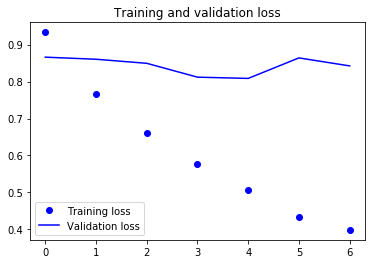

In [87]:
val_data = np.reshape(val_data, (val_data.shape[0], 600, 64))
prediction = model.predict(val_data, verbose=0)
prediction = prediction.mean(axis=1)
print(prediction.shape)
prediction = np.reshape(prediction, (750, 1))
accu = detail(val_labels, prediction)
print('detail of training image')
print('for test accuracy is %f' % accu[0])
print('wrong prediction of train label', accu[1])
print('right prediction of train label', accu[2])
print('prediction of train label      ', accu[3])
print('true of train label            ', accu[4])
show_plot()


In [24]:
val_labels[1]

array([1., 0., 0.])

In [25]:
print(pred.shape, val_labels.shape)
#a=get_hot_value(pred)
pred[0, :, 0]


NameError: name 'pred' is not defined

In [26]:
for i in range (0,len(model_result)):
    print(model_result[i], 'vs',val_labels[i])


NameError: name 'model_result' is not defined

In [88]:
model.save('hw5_GRU_10.h5')